<a href="https://colab.research.google.com/github/mahavird/fsdl_project/blob/main/notebooks/MC_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MC Dropout Experiments

### Following is the setup:
1. Pytorch
2. MNIST dataset
3. Lenet

### Start with importing the required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm


### Making a dropout class for experimentation, although standard dropout class is available from pytorch

In [2]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        # multiplier is 1/(1-p). Set multiplier to 0 when p=1 to avoid error...
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        # if model.eval(), don't apply dropout
        if not self.training:
            return input
        
        # So that we have `input.shape` numbers of Bernoulli(1-p) samples
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        
        # To support both CPU and GPU.
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
            
        # Multiply output by multiplier as described in the paper [1]
        return torch.mul(selected_,input) * self.multiplier_


### Loading the datasets and visulaizing it

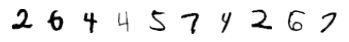

label: [2 6 4 4 5 7 4 2 6 7]
image data shape: (1, 28, 28)


In [4]:
transform = transforms.Compose([transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)


### Defining the model 

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        
        # Add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # Turn to 1D
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x


### Defining the classifier

In [6]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=10, \
                 lr=0.1, momentum=0):
        # Wrap MLP model
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        # Used to keep all test errors after each epoch
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)


### As training might take time, we download the weights provided by authors.

In [8]:
!git clone https://github.com/xuwd11/Dropout_Tutorial_in_PyTorch.git

Cloning into 'Dropout_Tutorial_in_PyTorch'...
remote: Enumerating objects: 455, done.
remote: Total 455 (delta 0), reused 0 (delta 0), pack-reused 455
Receiving objects: 100% (455/455), 334.98 MiB | 31.66 MiB/s, done.
Resolving deltas: 100% (238/238), done.
Checking out files: 100% (84/84), done.


### Loading the weights and error file

### Note: you can train your model too

In [10]:
hidden_layers = [800, 800]

### Below is training code, uncomment to train your own model... ###
### Note: You need GPU to run this section ###
'''
# Define networks
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(trainset, testset,verbose=False) for mlp in mlp1]

# Save torch models
for ind, mlp in enumerate(mlp1):
    torch.save(mlp.model, 'mnist_mlp1_'+str(ind)+'.pth')
    # Prepare to save errors
    mlp.test_error = list(map(str, mlp.test_error))

# Save test errors to plot figures
open("mlp1_test_errors.txt","w").write('\n'.join([','.join(mlp.test_error) for mlp in mlp1])) 
'''

# Load saved models to CPU
mlp1_models = [torch.load('Dropout_Tutorial_in_PyTorch/submit/mnist_mlp1_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1,2]]

# Load saved test errors to plot figures.
mlp1_test_errors = [error_array.split(',') for error_array in open("Dropout_Tutorial_in_PyTorch/submit/mlp1_test_errors.txt","r").read().split('\n')]
mlp1_test_errors = np.array(mlp1_test_errors,dtype='f')



### Plotting model "Number of errors in test set" vs expochs for following configuration of models:
1. 'MLP no dropout',
2. 'MLP 50% dropout in hidden layers',
3. 'MLP 50% dropout in hidden layers + 20% in input layer'

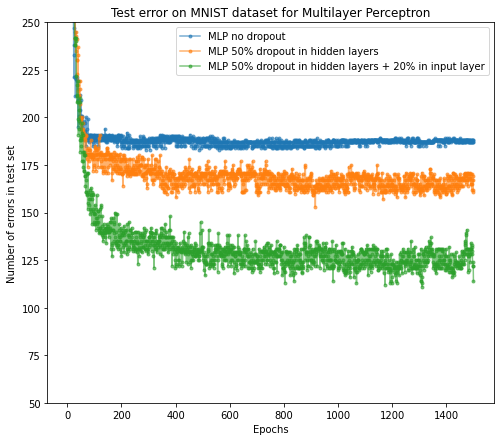

In [11]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()


In [12]:
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [28]
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
print(d)


[28, 28, 14, 14, 7]


### Defining Lenet Model Class

In [13]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)


### Building Lenet Model Classifier

In [14]:
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=128, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        self.test_error = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred


In [15]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###
'''
# Define networks
lenet1 = [LeNetClassifier(droprate=0, max_epoch=1500),
          LeNetClassifier(droprate=0.5, max_epoch=1500)]
        
# Training, set verbose=True to see loss after each epoch.
[lenet.fit(trainset, testset,verbose=False) for lenet in lenet1]

# Save torch models
for ind, lenet in enumerate(lenet1):
    torch.save(lenet.model, 'mnist_lenet1_'+str(ind)+'.pth')
    # Prepare to save errors
    lenet.test_error = list(map(str, lenet.test_error))

# Save test errors to plot figures
open("lenet1_test_errors.txt","w").write('\n'.join([','.join(lenet.test_error) for lenet in lenet1])) 
'''

# Load saved models to CPU
lenet1_models = [torch.load('Dropout_Tutorial_in_PyTorch/submit/mnist_lenet1_'+str(ind)+'.pth', map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

# Load saved test errors to plot figures.
lenet1_test_errors = [error_array.split(',') for error_array in 
                      open("Dropout_Tutorial_in_PyTorch/submit/lenet1_test_errors.txt","r").read().split('\n')]
lenet1_test_errors = np.array(lenet1_test_errors,dtype='f')


### Plotting model "Number of errors in test set" vs expochs for following configuration of models:
1. 'MLP no dropout',
2. 'MLP 50% dropout in hidden layers',
3. 'MLP 50% dropout in hidden layers + 20% in input layer'
4. Lenet with no dropout
5. Lenet 50% dropout


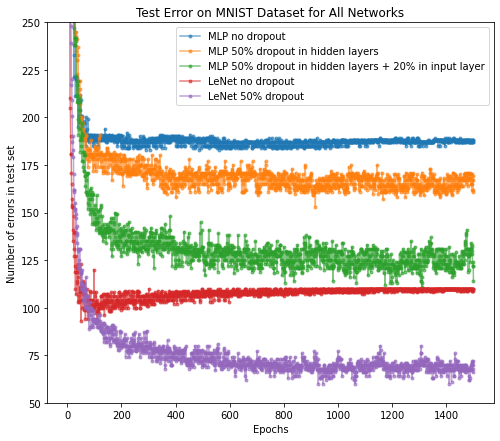

In [16]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer',
          'LeNet no dropout',
          'LeNet 50% dropout']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors.tolist() + lenet1_test_errors.tolist()):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test Error on MNIST Dataset for All Networks')
plt.show()


### Results on Test Set

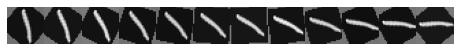

In [17]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(50, 130, 7)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');


### Predict functions for MC Dropout(1000 iterations)

In [44]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X))
        #print(len(_y1[1]))
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)


### Normal Prediction with model for 12 images with (MLP 50% dropout in hidden layers + 20% in input layer)

In [45]:
model = mlp1_models[2]

# Need to flatten X1 before feeding into MLP
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1.reshape(-1,784)))
print('Predictions: {}'.format(y1_pred))


Predictions: [1 1 1 1 1 1 7 7 4 6 4 4]


In [28]:
print(len(y1_pred),len(y1_si),len(y1_so))

12 1000 1000


In [35]:
print( len(y1_so[:, :, 7].flatten()))

12000


In [36]:
print(y1_si.shape[1])

12


In [33]:
y1_so[:, :, 7].flatten()

array([4.7034904e-02, 4.1451707e-04, 7.5660813e-05, ..., 3.6215138e-02,
       6.2861443e-07, 1.3820964e-02], dtype=float32)

### Plot scatter  plots after MC Droput layers(MLP 50% dropout in hidden layers + 20% in input layer)

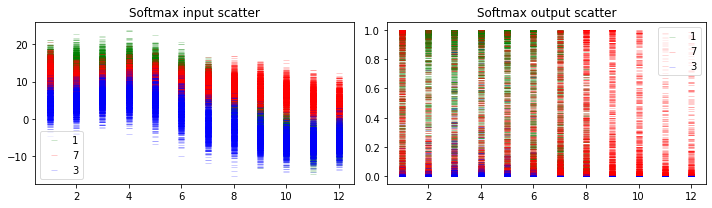

In [20]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)

plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();


**Observations:** There are three different classes shown in the prediction results above, 1, 7 and 3. As shown in the figure above, if they are well separated in the softmax output, we can get high confidence for predictions. However in some cases where there is overlap among the uncertainty envelopes for different classes, the uncertainty of prediction result will become higher as shown in middle ones in both plots.

### Prediction with LeNet 50% dropout

In [21]:
model = lenet1_models[1]
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))


Predictions: [7 3 3 5 5 5 5 7 7 7 7 7]


### Plot scatter  plots after MC Droput layers(LeNet 50% dropout)

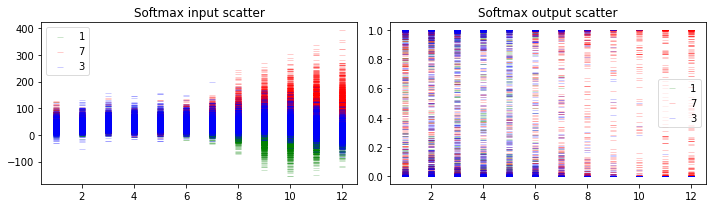

In [22]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();
